In [1]:
import torch
from torch import nn
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import requests
import os
import logging


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
logging.info(f"Using {device}")
device


'cuda'

In [3]:
class Util:
    def __init__(self):
        pass

    def lhs(self, n_samples: int, n_dims: int, dtype=torch.float64, show_plot: bool = False):
        spaces = torch.linspace(0, 1, n_samples + 1, dtype=dtype).to(device)

        # We need to unsqueeze so that we can use broadcasting on the n_dims
        lower_bound = spaces[:-1].unsqueeze(1)
        upper_bound = spaces[1:].unsqueeze(1)

        rand_idx = torch.rand(n_samples, n_dims, device=device)
        points = lower_bound + rand_idx * (upper_bound - lower_bound)

        if show_plot:
            self.print_2d_space(points)

        for i in range(n_dims):
            samples_idx = torch.randperm(n_samples, device=device)
            points[:,i] = points[samples_idx,i]

        if show_plot:
            self.print_2d_space(points)

        return points

    def print_2d_space(self, X):
        plt.scatter(X[:, 0].numpy(), X[:, 1].numpy(), color='blue', s=50)
        plt.show()



In [4]:
class WaveRawData:
    def __init__(self):
        x = np.linspace(0, 1, 1000)
        t = np.linspace(0, 1, 2000)

        T, X = np.meshgrid(t, x)

        u = np.sin(np.pi * X) * np.cos(10 * np.pi * T) + np.sin(2 * np.pi * X) * np.cos(20 * np.pi * T)

        self.X = X
        self.T = T
        self.u = u

In [5]:
wave_raw_data = WaveRawData()

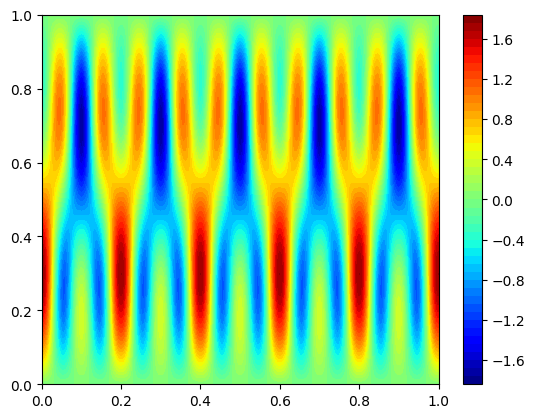

In [8]:
plt.contourf(wave_raw_data.T, wave_raw_data.X, wave_raw_data.u, levels=50, cmap="jet")
plt.colorbar()

In [6]:
class Util:
    def __init__(self):
        pass

    def lhs(self, n_samples: int, n_dims: int, dtype=torch.float, show_plot: bool = False):
        spaces = torch.linspace(0, 1, n_samples + 1, dtype=dtype).to(device)

        # We need to unsqueeze so that we can use broadcasting on the n_dims
        lower_bound = spaces[:-1].unsqueeze(1)
        upper_bound = spaces[1:].unsqueeze(1)

        rand_idx = torch.rand(n_samples, n_dims, device=device)
        points = lower_bound + rand_idx * (upper_bound - lower_bound)

        if show_plot:
            self.print_2d_space(points)

        for i in range(n_dims):
            samples_idx = torch.randperm(n_samples, device=device)
            points[:,i] = points[samples_idx,i]

        if show_plot:
            self.print_2d_space(points)

        return points

    def print_2d_space(self, X):
        plt.scatter(X[:, 0].numpy(), X[:, 1].numpy(), color='blue', s=50)
        plt.show()

util = Util()

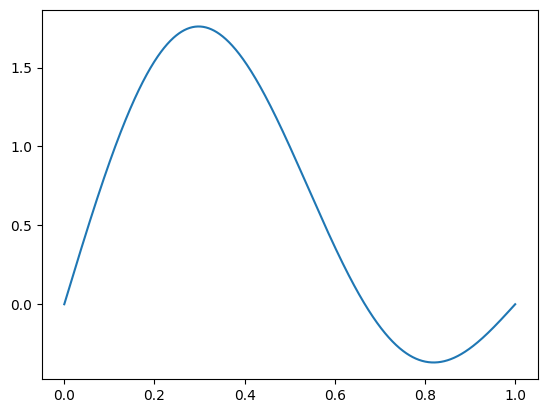

In [9]:
plt.plot(wave_raw_data.X[:,0], wave_raw_data.u[:,0])

In [7]:
class WaveData():
    def __init__(self, wave_raw_data: WaveRawData, n_data: int, n_boundary: int, n_collocation: int):
        x_bound = np.array([0, 1])
        t_bound = np.array([0, 1])

        all_x = torch.tensor(wave_raw_data.X[:,0], device=device, dtype=torch.float)

        rand_data_idx = torch.randint(0, all_x.shape[0], size=[n_data], device=device)

        x_data = all_x[rand_data_idx]
        x_data.requires_grad_(True)
        t_data = torch.zeros(size=(x_data.shape[0],), device=device, requires_grad=True)
        y_data = torch.tensor(wave_raw_data.u[:,0], device=device)

        t_boundary = torch.rand(size=(n_boundary,), device=device) * (t_bound[1] - t_bound[0]) + t_bound[0]

        x_low_boundary = torch.ones(t_boundary.shape[0], device=device) * x_bound[0]
        t_low_boundary = t_boundary.clone()

        x_high_boundary = torch.ones(t_boundary.shape[0], device=device) * x_bound[1]
        t_high_boundary = t_boundary.clone()

        x_ut_constraint = torch.rand(size=(n_boundary,), device=device) * (x_bound[1] - x_bound[0]) + x_bound[0]
        t_ut_constraint = torch.zeros(size=(x_ut_constraint.shape[0],), device=device, requires_grad=True)

        collocation_points = util.lhs(n_collocation, 2)
        x_collocation = x_bound[0] + collocation_points[:,0] * (x_bound[1] - x_bound[0])
        t_collocation = t_bound[0] + collocation_points[:,1] * (t_bound[1] - t_bound[0])

        x_collocation.requires_grad_(True)
        t_collocation.requires_grad_(True)


        self.x_data = x_data
        self.t_data = t_data
        self.y_data = y_data

        self.t_low_boundary = t_low_boundary
        self.x_low_boundary = x_low_boundary

        self.t_high_boundary = t_high_boundary
        self.x_high_boundary = x_high_boundary

        self.x_ut_constraint = x_ut_constraint
        self.t_ut_constraint = t_ut_constraint

        self.x_collocation = x_collocation
        self.t_collocation = t_collocation

In [9]:
class MLP(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.ff = nn.Sequential(
            nn.Linear(2, 100),
            nn.Tanh(),
            nn.Linear(100, 100),
            nn.Tanh(),
            nn.Linear(100, 100),
            nn.Tanh(),
            nn.Linear(100, 1)
        )

        self.apply(self._init_weights)

    def _init_weights(self, module):
        """Apply Xavier initialization to linear layers"""
        if isinstance(module, nn.Linear):
            # Xavier uniform initialization (also called Glorot uniform)
            nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                nn.init.zeros_(module.bias)

    def forward(self, x, t):
        X = torch.stack([x, t], dim=1)
        return self.ff(X)

In [10]:
class PINNLoss(nn.Module):
    def __init__(self) -> None:
        super().__init__()

    def forward(self, mlp: nn.Module, wave_data: WaveData) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        # Data loss
        u_data = mlp(wave_data.x_data, wave_data.t_data)
        data_loss = torch.mean((u_data - wave_data.y_data)**2)

        # # Boundary loss
        y_high_bound = mlp(wave_data.x_high_boundary, wave_data.t_high_boundary)
        y_low_bound = mlp(wave_data.x_low_boundary, wave_data.t_low_boundary)

        ut_boundary = mlp(wave_data.x_ut_constraint, wave_data.t_ut_constraint)
        u_t_boundary = torch.autograd.grad(
            torch.sum(ut_boundary),
            wave_data.t_ut_constraint,
            create_graph=True
        )[0]

        boundary_loss = (
            torch.mean(y_high_bound**2) + torch.mean(y_low_bound**2) +
            torch.mean(u_t_boundary**2)
        )

        # PDE loss
        u_collocation = mlp(wave_data.x_collocation, wave_data.t_collocation)

        u_t = torch.autograd.grad(
            torch.sum(u_collocation),
            wave_data.t_collocation,
            create_graph=True,
            retain_graph=True
        )[0]

        u_tt = torch.autograd.grad(
            torch.sum(u_t),
            wave_data.t_collocation,
            create_graph=True
        )[0]

        u_x = torch.autograd.grad(
            torch.sum(u_collocation),
            wave_data.x_collocation,
            create_graph=True,
            retain_graph=True
        )[0]

        u_xx = torch.autograd.grad(
            torch.sum(u_x),
            wave_data.x_collocation,
            create_graph=True,
        )[0]

        f_u = u_tt - 100 * u_xx
        pde_loss = torch.mean(f_u**2)

        # Total loss
        return boundary_loss, pde_loss, data_loss


In [19]:
wave_data = WaveData(wave_raw_data, 50, 50, 10000)

In [13]:
mlp = MLP().to(device)

optimizer = torch.optim.Adam(mlp.parameters())
criterion = PINNLoss()

In [11]:
def training_loop(epochs: int, model: nn.Module, optimizer: torch.optim.Optimizer):
    losses = []
    for i in range(epochs):
        optimizer.zero_grad()
        for dt in [
            wave_data.x_collocation,
            wave_data.t_collocation,

            wave_data.x_data,
            wave_data.t_data,

            wave_data.t_ut_constraint,
            wave_data.x_ut_constraint
        ]:
            dt.grad = None

        boundary_loss, pde_loss, data_loss = criterion(model, wave_data)

        loss = boundary_loss + pde_loss + data_loss

        # Backpropagation
        loss.backward()

        losses.append({
            'loss': loss.item(),
            'boundary_loss': boundary_loss.item(),
            'pde_loss': pde_loss.item(),
            'data_loss': data_loss.item()
        })

        optimizer.step()

        if i % 99 == 0:
            total_loss = [d['loss'] for d in losses]
            boundary_loss = [d['boundary_loss'] for d in losses]
            pde_loss = [d['pde_loss'] for d in losses]
            data_loss = [d['data_loss'] for d in losses]

            # Plot
            plt.figure(figsize=(4,2))
            plt.yscale('log')
            plt.plot(total_loss, label='Total Loss')
            plt.plot(boundary_loss, label='Boundary Loss')
            plt.plot(pde_loss, label='PDE Loss')
            plt.plot(data_loss, label='Data Loss')
            plt.legend()
            plt.show()


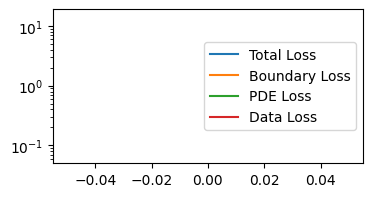

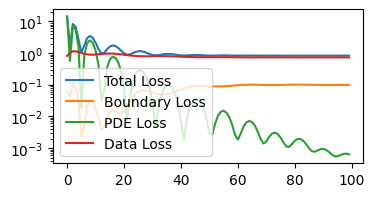

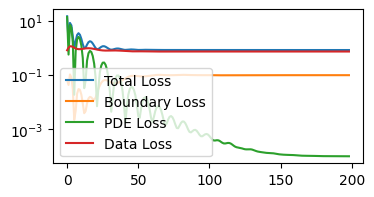

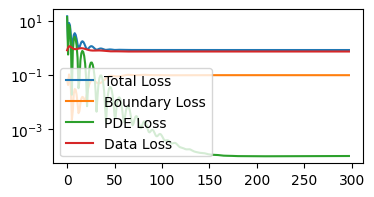

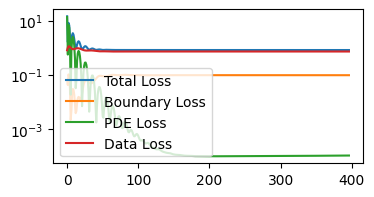

In [15]:
training_loop(400, mlp, optimizer)

In [18]:
x, t = torch.tensor(wave_raw_data.X.reshape(-1), dtype=torch.float, device=device), torch.tensor(wave_raw_data.T.reshape(-1), dtype=torch.float, device=device)
y = mlp(x, t)

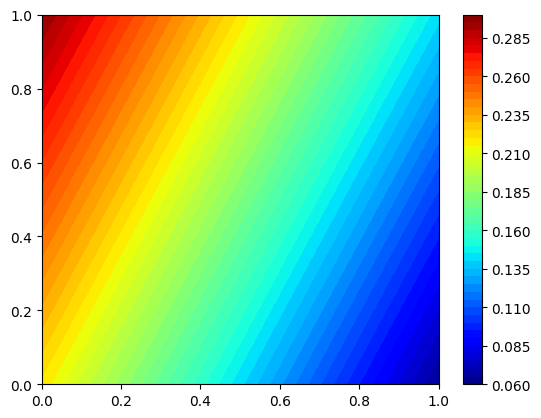

In [19]:
y_reshaped = y.reshape(wave_raw_data.u.shape[0], wave_raw_data.u.shape[1])

plt.contourf(wave_raw_data.T, wave_raw_data.X, y_reshaped.detach().cpu(), levels=50, cmap="jet")
plt.colorbar()

In [22]:
class MultiscaleFourierEmbedding(nn.Module):
    def __init__(self, in_dim: int, num_features: int, sigmas: list[float]):
        """
        Args:
            in_dim: input dimension (e.g. 2 for (x,t))
            num_features: number of random features per block
            sigmas: list of scales (one per block), e.g. [1.0, 10.0, 50.0]
        """
        super().__init__()
        self.in_dim = in_dim
        self.num_features = num_features
        self.sigmas = sigmas
        self.M = len(sigmas)

        # For each sigma, create a random projection matrix B^i
        # Shape: (M, num_features, in_dim)
        B = torch.randn(self.M, num_features, in_dim)
        self.register_buffer("B", B)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        x: (batch, in_dim)
        returns: (batch, M * 2 * num_features)
        """
        batch_size = x.shape[0]

        feats = []
        for i, sigma in enumerate(self.sigmas):
            proj = (x @ self.B[i].T) * sigma  # (batch, num_features)
            cos_feat = torch.cos(2 * torch.pi * proj)
            sin_feat = torch.sin(2 * torch.pi * proj)
            feats.append(torch.cat([cos_feat, sin_feat], dim=-1))

        return torch.cat(feats, dim=-1)  # (batch, M * 2 * num_features)

class FFMLP(nn.Module):
    def __init__(self, sigmas: float) -> None:
        super().__init__()
        self.embedding = MultiscaleFourierEmbedding(in_dim=2, num_features=2, sigmas=sigmas)
        self.ff = nn.Sequential(
            nn.Linear(12, 200),
            nn.Tanh(),
            nn.Linear(200, 200),
            nn.Tanh(),
            nn.Linear(200, 200),
            nn.Tanh(),
            nn.Linear(200, 1)
        )

        self.apply(self._init_weights)

    def _init_weights(self, module):
        """Apply Xavier initialization to linear layers"""
        if isinstance(module, nn.Linear):
            # Xavier uniform initialization (also called Glorot uniform)
            nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                nn.init.zeros_(module.bias)

    def forward(self, x, t):
        X = torch.stack([x, t], dim=1)
        y = self.embedding(X)
        y = self.ff(y)
        return y

In [23]:
ffmlp = FFMLP(sigmas=[1.0, 10.0, 50.0]).to(device)

optimizer = torch.optim.Adam(ffmlp.parameters())
criterion = PINNLoss()

In [24]:
optimizer = torch.optim.Adam(ffmlp.parameters())

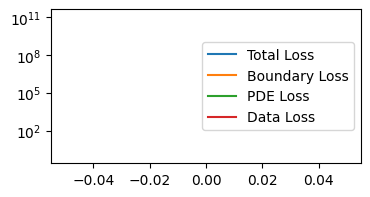

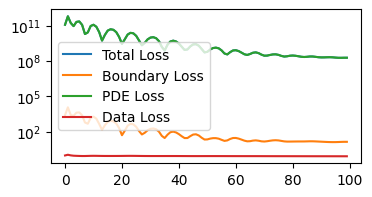

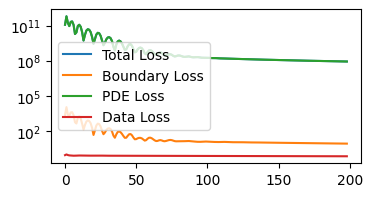

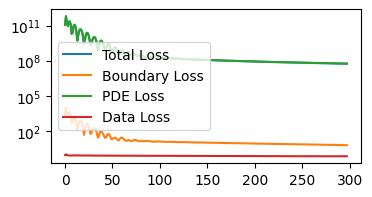

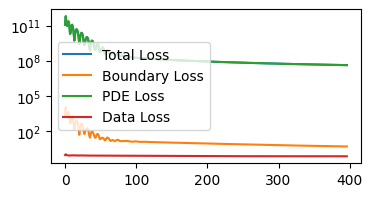

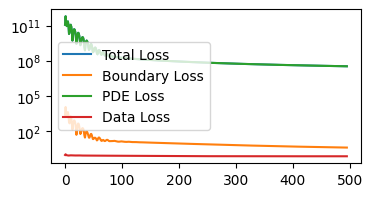

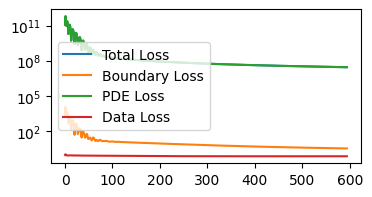

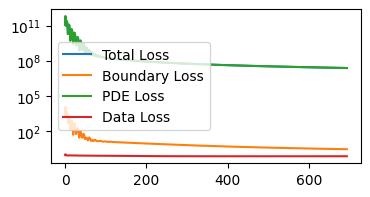

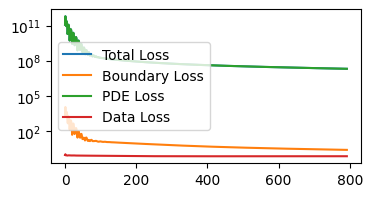

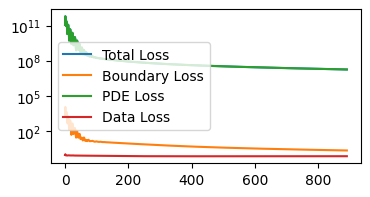

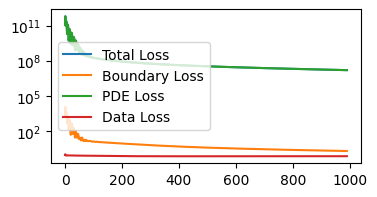

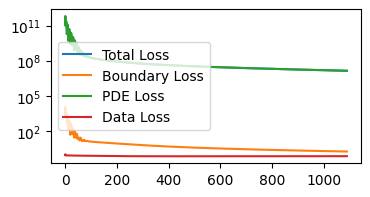

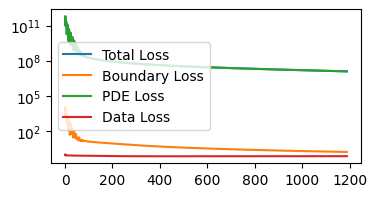

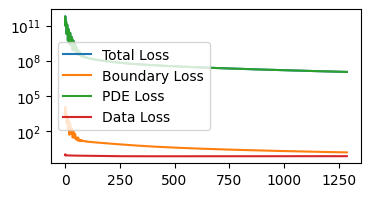

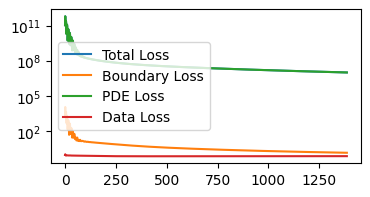

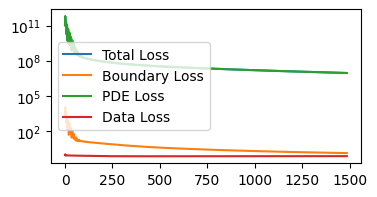

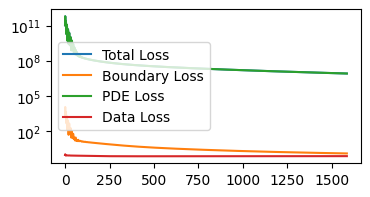

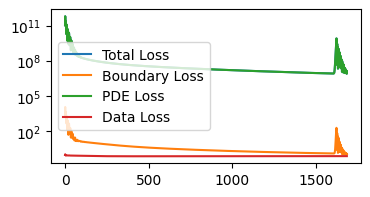

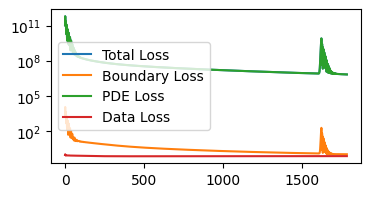

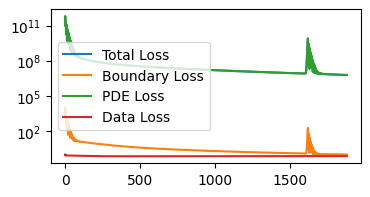

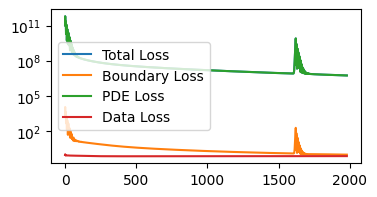

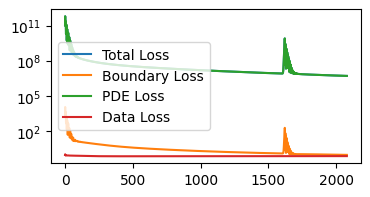

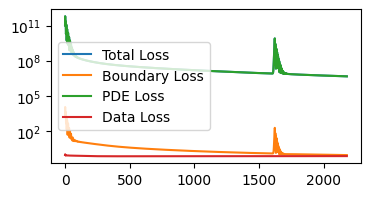

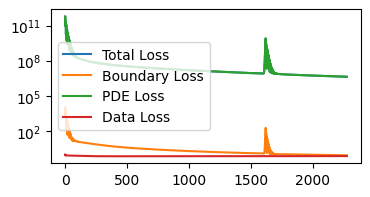

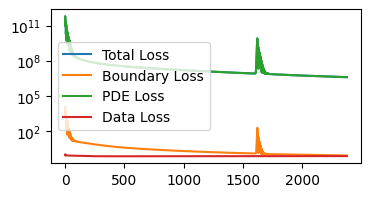

KeyboardInterrupt: 

In [25]:
training_loop(40000, ffmlp, optimizer)

In [51]:
x, t = torch.tensor(wave_raw_data.X.reshape(-1), dtype=torch.float, device=device), torch.tensor(wave_raw_data.T.reshape(-1), dtype=torch.float, device=device)
y = ffmlp(x, t)

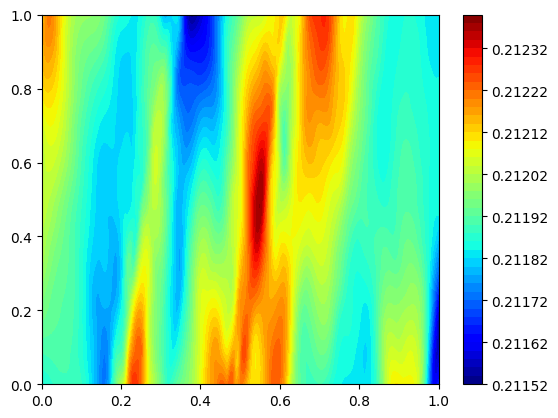

In [52]:
y_reshaped = y.reshape(wave_raw_data.u.shape[0], wave_raw_data.u.shape[1])

plt.contourf(wave_raw_data.T, wave_raw_data.X, y_reshaped.detach().cpu(), levels=50, cmap="jet")
plt.colorbar()

In [46]:
import torch
from google.colab import drive
drive.mount('/content/drive')  # mounts your Drive

# Suppose your model is called 'model' and optimizer 'optimizer'
checkpoint_path = "/content/drive/MyDrive/fourier_nn.pt"

torch.save({
    'model_state_dict': ffmlp.state_dict(),
    'optimizer_state_dict': optimizer.state_dict()
}, checkpoint_path)

print(f"Checkpoint saved to {checkpoint_path}")

Mounted at /content/drive
Checkpoint saved to /content/drive/MyDrive/fourier_nn.pt
